# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Описание данных

### Технологический процесс

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


### Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

### Наименование признаков
Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`<br>

Пример:

`rougher.input.feed_ag`


Возможные значения для блока `[этап]`:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики


Возможные значения для блока `[тип_параметра]`:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

# 1. Подготовка данных

#### 1.1. Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.dummy import DummyRegressor

#### 1.2 Откроем файлы и изучим их

In [2]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')

Напишем функцию, выводящую информацию о датасете.<br>Нас интересуют следующие характеристики:
- количество объектов и признаков
- количество пропущенных значений в признаках объектов
- количество нулевых значений в признаках объектов
- количество дубликатов

Также создадим словарь для упрощения итерации по нашим датасетам.

In [3]:
datasets = {'Обучающая выборка': train,
            'Тестовая выборка': test,
            'Исходные данные': full}

In [4]:
def eda(key):
    
    print(key+':', '\n')
    
    print(datasets[key].info(), '\n')
    
    print('Количество дупликатов:', datasets[key].duplicated().sum(), '\n')
    print('Количество пропущенных значений:', datasets[key].isnull().sum().sum(),
          (datasets[key].isnull().sum().sum()) / (len(datasets[key]) * len(datasets[key].columns)) * 100, '%', '\n')
    print('Общее количество  нулевых значений в датасете:',(datasets[key] == 0).sum().sum(), '\n')
    
    print('Признаки, имеющие нулевые значения и их количество:', '\n')
    
    counter = 0
    for column in datasets[key].columns:
        if (datasets[key][column] == 0).sum() != 0:
            print(column, (datasets[key][column] == 0).sum())
            counter += 1
    print('\n','Общее количество признаков, имеющих нулевые значения:', counter)

#### 1.2.1 Обучающая выборка

In [5]:
eda('Обучающая выборка')

Обучающая выборка: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.de

**Вывод:**

- Обучающая выборка содержит **16860** объектов, которые имеют **87** признаков
- 1 категориальный признак **date** (в дальнейшем потребуется замена типа данных), отображающий дату сбора данных об объекте, остальные признаки являются количественными.
- В датасете присутствует **30320** пустых значений (~2.1% от всех наблюдений) и значительное количество нулевых значений - **47571**. Можно предположить, что на момент взятия образцы веществ, связанных с данными признаками, отсутствовали в концентрате.
- Дубликаты отсутствуют.

#### 1.2.2 Тестовая выборка

In [6]:
eda('Тестовая выборка')

Тестовая выборка: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-nul

**Вывод:**

- Тестовая выборка содержит **5856** объектов и **53** признака (количество признаков значительно отличается от количества признаков обучающей выборки в меньшую сторону).
- Тестовая выборка, так же как и обучающая, содержит категориальный признак date.
- Присутствует **2360** пропущенных значений, что составляет **0.76%** от всего датасета. Количество нулевых значений - **2450**.
- Дубликаты отсутствуют.

#### 1.2.3 Исходные данные

In [7]:
eda('Исходные данные')

Исходные данные: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depr

**Вывод:**

- датасет с исходными данными содержит информацию о **22716** объектах, имеющих 87 признаков (как и в обучающей выборке).
- имеет **36587** пропущенных значений, что составляет **1.85%** от всего датасета и **60015** ячеек с нулевыми значениями.
- количество признаков, имеющих нулевые значения, соответсвует аналогичному показателю обучающей выборки и равно 42.
- дубликаты отсутствуют

####  1.3 Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака **rougher.output.recovery**. Найдём **MAE** между нашими расчётами и значением признака. Опишем выводы.

Известно, что эффективность обогащения рассчитывается по формуле:

$$ Recovery = \frac{C × (F-T)}{F × (C-T)} × 100%$$

Где:

- **C** — доля золота в концентрате после флотации/очистки;
- **F** — доля золота в сырье/концентрате до флотации/очистки;
- **T** — доля золота в отвальных хвостах после флотации/очистки.

Изучив датасеты, можно прийти к выводу, что:

- Значению **C** соответствует признак `rougher.output.concentrate_au`
- Значению **F** соответствует признак `rougher.input.feed_au`
- Значению **T** соответствует признак `rougher.output.tail_au`
- Значению **Recovery** соответствует признак ``rougher.output.recovery``

Обучающая выборка содержит все вышеупомянутые признаки.

Вычислим значение **Recovery** на обучающих данных и сравним его с фактическим значением данного признака, который уже присутствует в датасете:

In [8]:
#создадим временную переменную - полную и независимую копию тренировочного датасета:

train_temp = datasets['Обучающая выборка'].copy(deep=True)

#присвоим переменным соответствующие значения:
C = train_temp['rougher.output.concentrate_au']
F = train_temp['rougher.input.feed_au']
T = train_temp['rougher.output.tail_au']

Рассчитаем новое значение и вычислим метрику **MAE**, предварительно избавившись от пропусков в датасете:

In [9]:
train_temp['rougher.output.recovery.new'] = (C * (F - T)) / (F * (C - T)) * 100

train_temp.dropna(inplace=True)
print('MAE:', mean_absolute_error(train_temp['rougher.output.recovery'],
                                  train_temp['rougher.output.recovery.new']))

del train_temp

MAE: 9.555596961987514e-15


**Вывод:** 
Значение средней абсолютной ошибки близко к нулю, что может свидетельствовать о том, что значение **Recovery** изначально было рассчитано корректно.

#### 1.4. Проанализируем признаки, недоступные в тестовой выборке. Посмотрим, что это за параметры и к какому типу они относятся

Ранее было замечено, что количество признаков в тестовой выборке отличается от аналогичного значения обучающей выборки в меньшую сторону. Посмотрим, какие именно признаки отсутствуют:

In [10]:
set(datasets['Обучающая выборка'].columns) - set(datasets['Тестовая выборка'].columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Вывод:**
Можем заметить, что в тестовой выборке отсутствуют целевые признаки, без которых проверка обученной модели будет невозможна:
- **final.output.recovery**
- **rougher.output.recovery**

Также отсутствует значительное количестно признаков **output** (параметры продукта) и **calculations** (расчётные характеристики). Как следует из описания проекта, из-за многоэтапности процесса обработки сырья, некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже.

Предварительный анализ данных показал, что значения данных признаков имеют тип **float64**.

#### 1.4. Предобработка данных

Действия, необходимые в данном шаге:
- Создадим новые независимые переменные, содержащие обучающую, тестовую выборку и исходные данные
- Добавим в тестовую выборку целевые признаки - **final.output.recovery** и **rougher.output.recovery**
- Обработаем пропуски в данных
- Заменим тип данных признаков **date** на **datetime**
- Так как многие признаки в тестовой выборке отсутствуют, оставим в обучающей выборке лишь те признаки, которые присутствуют в тестовой

Создадим новые переменные, содержащие независимые копии изначальных датасетов.

In [11]:
train_copy = train.copy(deep=True)
test_copy = test.copy(deep=True)
full_copy = full.copy(deep=True)

Заменим тип данных признака **date** на **datetime**:

In [12]:
train_copy['date'] = pd.to_datetime(train_copy['date'])
test_copy['date'] = pd.to_datetime(test_copy['date'])
full_copy['date'] = pd.to_datetime(full_copy['date'])

Добавим целевые признаки в тестовую выборку:

In [13]:
test_copy = test_copy.merge(full_copy[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                           how = 'left', on = 'date')

#проверим
test_copy[['date', 'rougher.output.recovery']].head(3)

,date,rougher.output.recovery
0,2016-09-01 00:59:59,89.993421
1,2016-09-01 01:59:59,88.089657
2,2016-09-01 02:59:59,88.412756


Избавимся от строк с пропусками целевых признаков:

In [14]:
#создадим словарь датасетов для избежания дублирования кода:
datasets_copy = {'Обучающая выборка': train_copy,
                 'Тестовая выборка': test_copy,
                 'Исходные данные': full_copy}

In [15]:
for key, value in datasets_copy.items():
    value = value.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

Заполним пропуски в остальных признаках:

In [16]:
for key, value in datasets_copy.items():
    value.fillna(method='ffill',inplace=True)
    if value.isnull().values.any() == 0:
        print('В датасете "{}" пропуски отсутствуют'.format(key))

В датасете "Обучающая выборка" пропуски отсутствуют
В датасете "Тестовая выборка" пропуски отсутствуют
В датасете "Исходные данные" пропуски отсутствуют


Удалим из обучающей выборки те признаки, которые отсутствуют в тестовой и проверим, равно ли количество признаков в них после обработки:

In [17]:
train_copy = train_copy[list(test_copy.columns)]

print(train_copy.shape)
print(test_copy.shape)

(14149, 55)
(5290, 55)


**Вывод по шагу:**
- Мы загрузили и изучили данные: выяснили, что в данных присутствует некоторое количество пропусков и нулевых значений и в тестовой выборке количество признаков меньше, чем таковое значение в остальных выборках. Дубликаты отсутствуют.
- После расчётов мы убедились, что эффективность обогащения изначально была рассчита корректно.
- Провели предобработку данных: пропуски были заменены на последние значения наблюдений.
- Также был заменён тип данных признака **date**, что позволило эффективно дополнить тестовую выборку целевыми признаками из исходного датасета, используя признак **date** для индексации.
- Т.к. в обучающей выборке количество признаков значительно превышало количество признаков тестовой выборки, мы оставили в обучающей выборке только те признаки, которые присутствуют в проверочной и убедились, что их количество совпадает.

# 2. Анализ данных

#### 2.1 Проанализируем, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Известно, что в процессе обработки сырья обозначены 4 этапа:
- **rougher** — флотация
- **primary_cleaner** — первичная очистка
- **secondary_cleaner** — вторичная очистка
- **final** — финальные характеристики

Так как в наименовании признаков у нас присутствует наименование метала в виде индекса, обозначающего химический элемент, мы с лёгкостью можем обратиться к нужному признаку, соответсвующему конкретному элементу.
Напишем функцию, принимающую в качестве аргумента наименование металла и возвращающую диаграмму размаха, позволяющую визуально оценить изменения концентрации металлов на каждом из этапов:

In [18]:
elems = {'Золото': 'au',
         'Серебро': 'ag',
         'Свинец': 'pb'}

In [19]:
def sns_boxplot(elem):
    stages = full_copy[['rougher.input.feed_'+elem, 'rougher.output.concentrate_'+elem,
                            'primary_cleaner.output.concentrate_'+elem, 'final.output.concentrate_'+elem]]
    
    f = plt.figure(figsize=[15,10])
    ax = f.add_subplot(111)
    plt.title('Концентрация ' + str(elem) + ' на различных этапах очистки', fontsize=14)
    plt.xlabel('Этапы')
    plt.ylabel('Концентрация')

    
    sns.boxplot(data=stages, ax=ax)
    plt.show()

**Концентрация золота:**

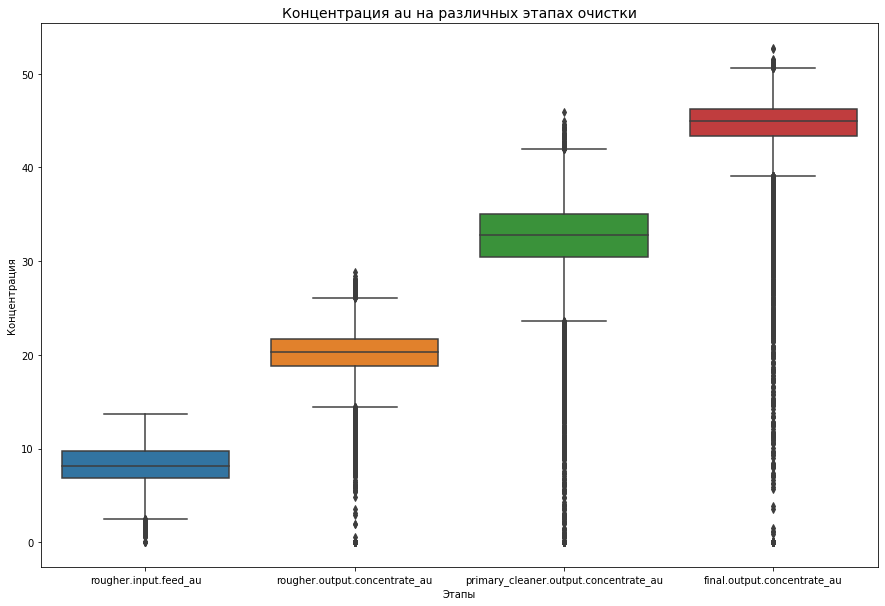

In [20]:
sns_boxplot(elems['Золото'])

Можно заметить, что концентрация золота стабильно увеличивается с каждым этапом очистки и это вполне логично, учитывая, что технологический процесс на это и рассчитан.<br>
Также можно заметить наличие выбросов на всех этапах обработки.

**Cеребро:**

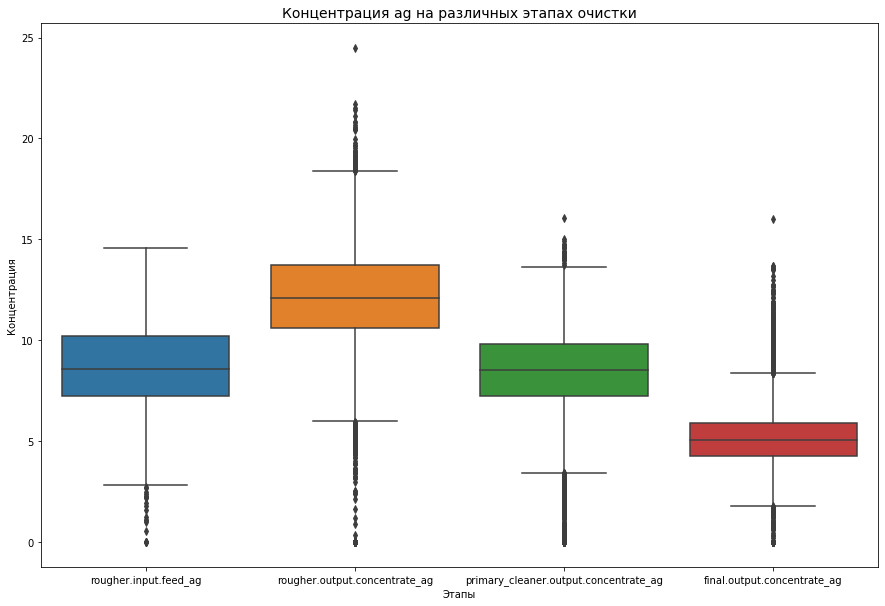

In [21]:
sns_boxplot(elems['Серебро'])

Видно, что после флотации концентрация серебра увеличилась, но на следующих этапах видно значительное снижение концентрации.<br>
Выбросы также присутствуют.

**Свинец:**

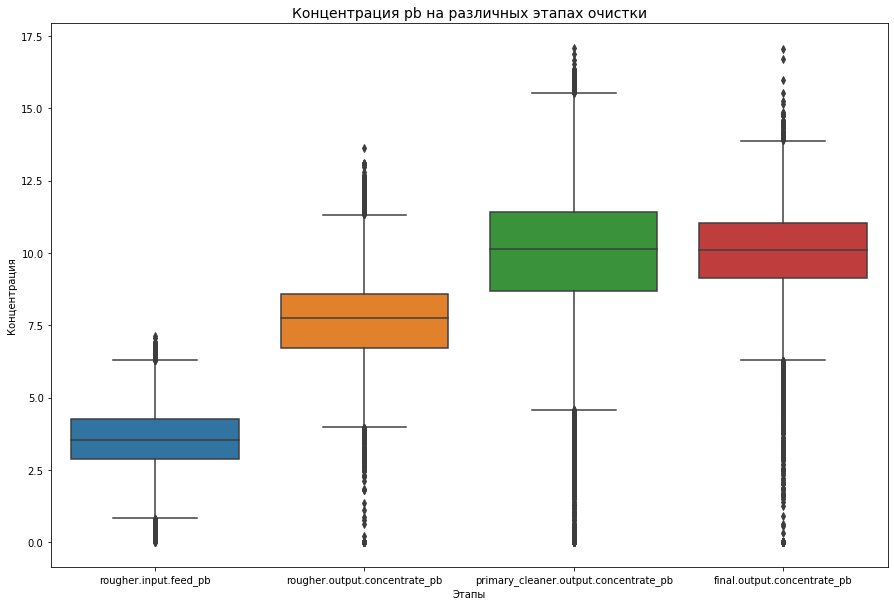

In [22]:
sns_boxplot(elems['Свинец'])

По графику видно, что концентрация свинца до флотации минимальна, после же флотации его концентрация возрастает вплоть до первичной очистки. После вторичной очистки медианное значение не изменилось, но разброс значений стал меньше.

Можно сделать вывод, что свинец труднее всего отделить от остальной породы в процессе очистки.

#### 2.2 Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
Известно, что размер гранул отображают 2 признака:
- **rougher.input.feed_size** - исходное сырьё
- **primary_cleaner.input.feed_size** - первичная очистка

На основе данных признаков выведем статистические описания и графики распределения для обучающей и тестовой выборки и сравним их.

,Обучающая,Тестовая
count,14149.000000,5290.000000
mean,60.239856,55.952754
std,23.005310,19.080334
min,9.659576,0.046369
25%,48.966751,43.906504
50%,55.269784,50.846843
75%,66.007526,62.451165
max,484.967466,392.494040


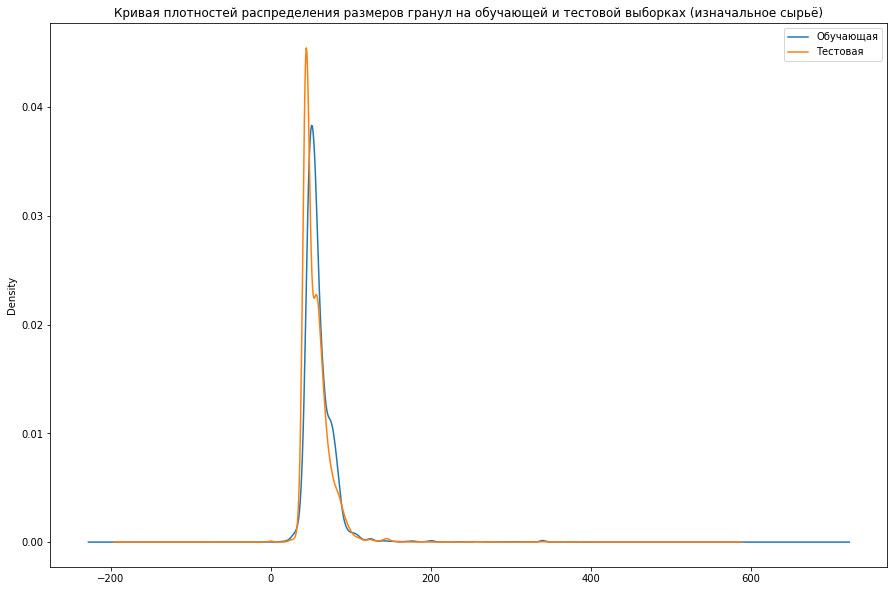

In [23]:
#объединим информацию из обучающей и тестовой выборки
rougher_input = pd.concat([train_copy['rougher.input.feed_size'], 
                                     test_copy['rougher.input.feed_size']], axis=1) 
rougher_input.columns = ['Обучающая', 'Тестовая']

display(rougher_input.describe())

plt.subplots(figsize=(15, 10))
rougher_input['Обучающая'].plot.kde()
rougher_input['Тестовая'].plot.kde()
plt.legend(rougher_input.columns)
plt.title('Кривая плотностей распределения размеров гранул на обучающей и тестовой выборках (изначальное сырьё)')

plt.show()

Медианные значения, как и Q1 и Q3 отличаются незначительно, графики распределения также выглядят схожим образом.
Аналогично, сравним показатели по наблюдениям на момент первичной очистки:

,Обучающая,Тестовая
count,14149.000000,5290.000000
mean,7.322310,7.266339
std,0.614062,0.610219
min,1.080000,5.650000
25%,6.960000,6.890000
50%,7.290000,7.250000
75%,7.700000,7.600000
max,10.470000,15.500000


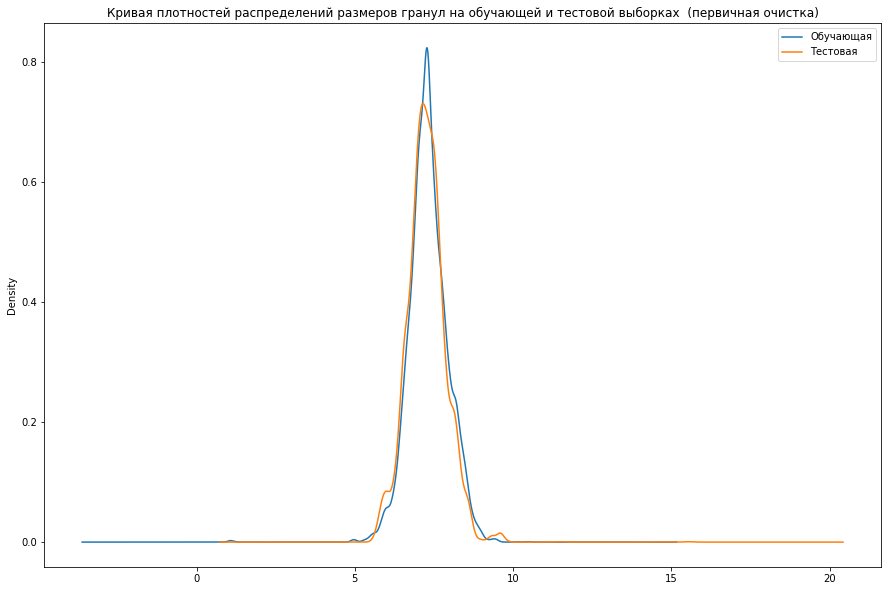

In [24]:
primary_cleaner = pd.concat([train_copy['primary_cleaner.input.feed_size'], 
                                     test_copy['primary_cleaner.input.feed_size']], axis=1) 
primary_cleaner.columns = ['Обучающая', 'Тестовая']

display(primary_cleaner.describe())

plt.subplots(figsize=(15, 10))
primary_cleaner['Обучающая'].plot.kde()
primary_cleaner['Тестовая'].plot.kde()
plt.legend(primary_cleaner.columns)
plt.title('Кривая плотностей распределений размеров гранул на обучающей и тестовой выборках  (первичная очистка)')

plt.show()

Можно заметить, что наблюдения на момент первичной очистки отличаются друг от друга ещё меньше. Q1, Q2 и медианные значения практически равны и на графике можно заметить распределение, близкое к нормальному как для обучающей, так и для тестовой выборки.


**Вывод:** различия незначительны и не должны помешать работе модели.

#### 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Поищем аномалии в данных и, если они есть, примем решение об их удалении.
Судя по описанию данных, в данный момент нас интересуют 4 характеристики, каждой из которых соответвует определённой стадии (**флотация**, **первичная очистка**, **вторичная очистка** и **финальные характеристики**). Им же, в свою очередь, соответствуют следующие признаки:
- **rougher.input.feed_{}**
- **rougher.output.concentrate_{}**
- **primary_cleaner.output.concentrate_{}**
- **final.output.concentrate_{}**

Создадим новые столбцы в копии исходного датасета, посчитав сумму соответствующих столбцов по каждому из веществ:

In [25]:
rougher = 'rougher.input.feed_'
rougher_conc = 'rougher.output.concentrate_'
primary = 'primary_cleaner.output.concentrate_'
final = 'final.output.concentrate_'

full_copy['сырьё'] = full_copy[[rougher+'au', rougher+'ag', rougher+'pb']].sum(axis=1)
full_copy['черновой концентрат'] = full_copy[[rougher_conc+'au', rougher_conc+'ag', rougher_conc+'pb']].sum(axis=1)
full_copy['концентрат после очистки'] = full_copy[[primary+'au', primary+'ag', primary+'pb']].sum(axis=1)
full_copy['финальный концентрат'] = full_copy[[final+'au', final+'ag', final+'pb']].sum(axis=1)

In [26]:
rougher = 'rougher.input.feed_'
rougher_conc = 'rougher.output.concentrate_'
primary = 'primary_cleaner.output.concentrate_'
final = 'final.output.concentrate_'

full_copy['сырьё'] = full_copy[[rougher+'au', rougher+'ag', rougher+'pb', rougher+'sol']].sum(axis=1)
full_copy['черновой концентрат'] = full_copy[[rougher_conc+'au', rougher_conc+'ag', rougher_conc+'pb',
                                              rougher_conc+'sol']].sum(axis=1)
full_copy['концентрат после очистки'] = full_copy[[primary+'au', primary+'ag', primary+'pb', primary+'sol']].sum(axis=1)
full_copy['финальный концентрат'] = full_copy[[final+'au', final+'ag', final+'pb', final+'sol']].sum(axis=1)

,сырьё,черновой концентрат,концентрат после очистки,финальный концентрат
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,57.320789,68.170865,60.764731,68.653624
std,7.212680,12.491279,10.017271,7.427536
min,0.040000,0.000000,0.000000,0.000000
25%,53.557679,66.012495,58.929364,67.932362
50%,57.594391,70.181495,62.497674,69.598444
75%,61.953459,74.356904,65.667336,71.368472
max,76.978947,88.140119,80.749343,80.210644


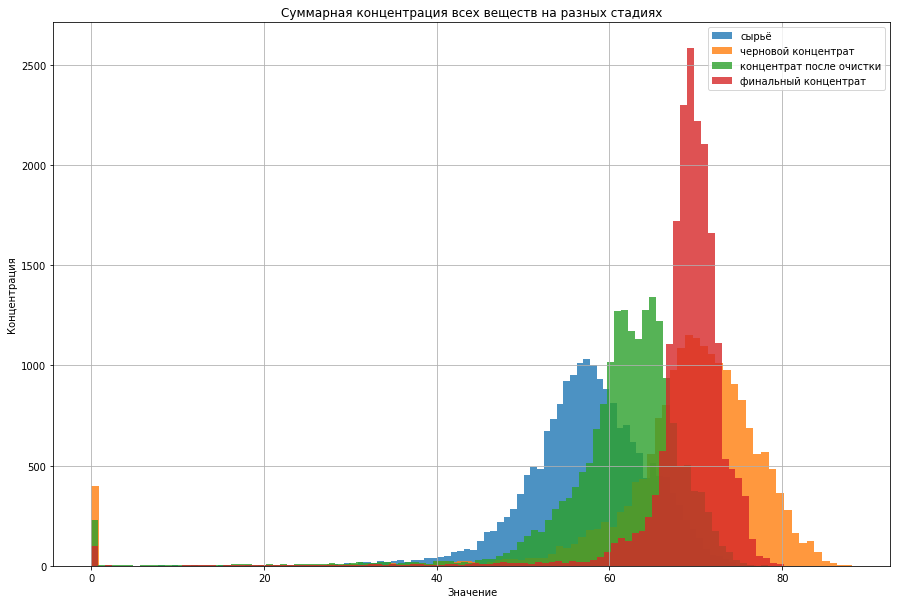

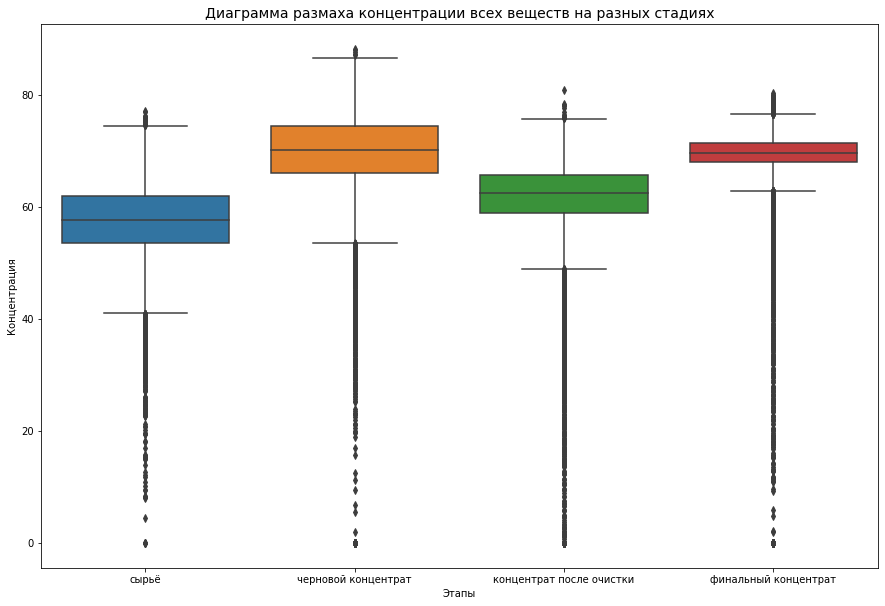

In [27]:
display(full_copy[['сырьё', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].describe())

plt.subplots(figsize=(15, 10))
full_copy['сырьё'].hist(bins=100, alpha=0.8)
full_copy['черновой концентрат'].hist(bins=100, alpha=0.8)
full_copy['концентрат после очистки'].hist(bins=100, alpha=0.8)
full_copy['финальный концентрат'].hist(bins=100, alpha=0.8)
plt.xlabel('Значение')
plt.ylabel('Концентрация')
plt.legend(['сырьё', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат'])
plt.title('Суммарная концентрация всех веществ на разных стадиях')

f = plt.figure(figsize=[15,10])
ax = f.add_subplot(111)
plt.title('Диаграмма размаха концентрации всех веществ на разных стадиях', fontsize=14)
plt.xlabel('Этапы')
plt.ylabel('Концентрация')

    
sns.boxplot(data=full_copy[['сырьё', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']], ax=ax)
plt.show()

Судя по describe() и графикам, в наших данных присутствуют значительные выбросы и, как и было замечено ранее при EDA, присутствуют нулевые значения, но уже по суммам металлов по этапам.
От этих выбросов следует избавиться, т.к. они могут ухудшить показатели работы модели.
Возьмём доверительный интервал по уровню 98% - это позволит отсечь все выбросы:

In [28]:
q_low = full_copy['сырьё'].quantile(0.01)
q_hi  = full_copy['сырьё'].quantile(0.99)

full_filtered = full_copy[(full_copy['сырьё'] < q_hi) & (full_copy['сырьё'] > q_low)]

for stage in ['черновой концентрат', 'концентрат после очистки', 'финальный концентрат']:
    q_low = full_filtered[stage].quantile(0.01)
    q_hi  = full_filtered[stage].quantile(0.99)
    
    full_filtered = full_filtered[(full_filtered[stage] < q_hi) & (full_filtered[stage] > q_low)]

In [29]:
full_filtered[['сырьё', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].describe()

,сырьё,черновой концентрат,концентрат после очистки,финальный концентрат
count,17708.000000,17708.000000,17708.000000,17708.000000
mean,57.467575,69.606060,61.397888,69.295656
std,6.367820,7.113242,7.092942,3.746473
min,34.592092,21.912641,0.113023,37.851504
25%,53.603122,66.340533,59.090632,67.994371
50%,57.582546,70.270640,62.440872,69.589223
75%,61.884810,74.300338,65.466626,71.306904
max,71.320506,83.149153,72.474375,76.450577


Можно заметить, что после фильтрации исчезли нулевые значения концентрата и показатели стандартного отклонения также улучшились - от аномалий избавились.

Перед обучением модели следует также отфильтровать данные объекты из обучающего и тестового датасета:

In [30]:
train_filtered = train_copy[train_copy['date'].isin(full_filtered['date'])]
test_filtered = test_copy[test_copy['date'].isin(full_filtered['date'])]

Проверим, присутствуют ли пропуски и сравним размер выборок:

In [31]:
print(train_filtered.isna().sum().sum())
print(test_filtered.isna().sum().sum())

print(train_filtered.shape)
print(test_filtered.shape)

0
0
(12925, 55)
(4783, 55)


**Вывод по шагу:**

- Мы рассмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки:
    - Концентрация золота стабильно увеличивается с каждым этапом очистки.
    - После этапа флотации концентрация серебра увеличилась, но на следующих этапах видно значительное снижение концентрации.
    - Концентрация свинца до флотации минимальна, после же флотации его концентрация возрастает вплоть до первичной очистки. После вторичной очистки медианное значение не изменилось, но разброс значений стал меньше.
- Мы сравнили распределения размеров гранул сырья на обучающей и тестовой выборках - они отличаются незначительно и данные различия не должны препятствовать обучению модели.
- Мы исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении - присутствовало большое количество аномальных нулевых значений, от которых мы избавились.

Выборки для обучения и проверки готовы и теперь можно приступить к подбору оптимальной модели для обучения.

# 3. Модель

#### 3.1. Напишем функцию для вычисления sMAPE и итоговой sMAPE.

Напишем функцию для расчета метрики **sMAPE**, которая вычисляется по формуле:
$$ sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} × 100% $$

Где:

- $y_i$ — Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
- $\hat{y_i}$ — Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
- N — Количество объектов в выборке.
- $\sum_{i=1}^{N}$ — Суммирование по всем объектам выборки (i меняется от 1 до N).

In [32]:
def smape(target, predictions):
    summ = (abs(predictions - target) / ((abs(target) + abs(predictions)) / 2)).sum()
    return 1 / len(target) * summ * 100

Напишем функцию для расчета метрики **итогового sMAPE**, которая вычисляется по формуле:

$$ sMAPE final = 0.25 × sMAPE(rougher) + 0.75 × sMAPE(final)$$

In [33]:
def smape_final(smape_rougher, smape_fin):
    smape_fin = 0.25 * smape_rougher + 0.75 * smape_fin
    return smape_fin

#### 3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. Опишем выводы.

В качестве моделей протестируем модель Случайный лес и Линейная регрессия. Обучать модели будем на данных по признакам сырья и финального продукта.
Для начала, разделим признаки и целевые признаки для обучающей и проверочной выборок:

In [34]:
#обучающая выборка:

target_rougher_train = train_filtered['rougher.output.recovery']
target_final_train = train_filtered['final.output.recovery']
features_train = train_filtered.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

#проверочная выборка:

target_rougher_test = test_filtered['rougher.output.recovery']
target_final_test = test_filtered['final.output.recovery']
features_test = test_filtered.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

#сравним размерность выборок:

print('Обучающая выборка', features_train.shape)
print('Проверочная выборка', features_test.shape)

Обучающая выборка (12925, 52)
Проверочная выборка (4783, 52)


Модели показывают лучшие результаты, когда признаки масштабированы - приведём их к единому масштабу:

In [35]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Обучим модель RandomForestRegressor и проверим её качество с помощью кросс-валидации.**

В модуле **cross_val_score** отсутствует возможность изпользования нужной нам метрики "из коробки", но есть возможность использовать ранее написанную функцию, используя **make_scorer** из библиотеки метрик sklearn:

In [36]:
scorer = make_scorer(smape, greater_is_better=False)
model = RandomForestRegressor(n_estimators=10, random_state=42)

cross_val_score_rougher_tree = cross_val_score(model, features_train, target_rougher_train, cv=5, scoring=scorer).mean()
cross_val_score_final_tree = cross_val_score(model,features_train, target_final_train, cv=5, scoring=scorer).mean()

print('cross_val_score_rougher_tree', cross_val_score_rougher_tree)
print('cross_val_score_final_tree', cross_val_score_final_tree)

cross_val_score_rougher_tree -7.249891917041284
cross_val_score_final_tree -9.667891932991203


**Обучим модель LinearRegression и проверим её качество с помощью кросс-валидации:**

In [37]:
model = LinearRegression()

cross_val_score_rougher_lr = cross_val_score(model, features_train, target_rougher_train, cv=5, scoring=scorer).mean()
cross_val_score_final_lr = cross_val_score(model,features_train, target_final_train, cv=5, scoring=scorer).mean()

print('cross_val_score_rougher_lr', cross_val_score_rougher_lr)
print('cross_val_score_final_lr', cross_val_score_final_lr)

cross_val_score_rougher_lr -7.444362806446895
cross_val_score_final_lr -10.615265420433834


Вывод: модель "Случайный лес" показала лучшие результаты.

Попробуем улучшить результаты работы модели с помощью подбора оптимальных гиперпараметров:

In [38]:
%%time

best_models = []
for depth in range(1,5):
    for n_estimator in range(10, 21, 5):
        
        model = RandomForestRegressor(random_state=42, n_estimators=n_estimator, max_depth=depth)
        
        cross_val_score_rougher_tree = cross_val_score(model, features_train, target_rougher_train, cv=5, scoring=scorer).mean()
        cross_val_score_final_tree = cross_val_score(model,features_train, target_final_train, cv=5, scoring=scorer).mean()
        
        smape_final_result = smape_final(cross_val_score_rougher_tree, cross_val_score_final_tree)
        
        best_models.append([model.get_params()['max_depth'], model.get_params()['n_estimators'], smape_final_result])
        print([model.get_params()['max_depth'], model.get_params()['n_estimators'], smape_final_result])

[1, 10, -8.80173378020965]
[1, 15, -8.838324220046557]
[1, 20, -8.84321635743985]
[2, 10, -8.450085946812953]
[2, 15, -8.428076371702913]
[3, 20, -8.253068093667983]
[4, 10, -8.222332241127148]
[4, 15, -8.178149537984778]
[4, 20, -8.142759942775292]
CPU times: user 2min 51s, sys: 135 ms, total: 2min 51s
Wall time: 2min 52s


Вывод: наилучшие результаты модель показывает при следующих значениях гиперпараметров:
- **max_depth=4**
- **n_estimators=10**
Модель готова для проверки на тестовой выборке.

Обучим модель "Случайный лес", используя подобранные ранее гиперпараметры:

In [39]:
model = RandomForestRegressor(max_depth=4, n_estimators=10, random_state=42)

model.fit(features_train, target_rougher_train)
predictions_rougher = model.predict(features_test)

model.fit(features_train, target_final_train)
predictions_final = model.predict(features_test)

print('Итоговый sMAPE:', smape_final(smape(target_rougher_test, predictions_rougher),
                                     smape(target_final_test, predictions_final)))

Итоговый sMAPE: 7.0263526540506716


Ошибка обученной модели составляет 7.02%.<br>
Следует проверить модель на адекватность, сравнив результат её работы с константной моделью.<br>
В качестве константной модели будем использовать модель **DummyRegressor**, обученную таким образом, что она всегда будет предсказывает только среднее значение целевого признака:

In [40]:
dummy = DummyRegressor(strategy='mean')

dummy.fit(features_train, target_rougher_train)
predictions_rougher_dummy = dummy.predict(features_test)

dummy.fit(features_train, target_final_train)
predictions_final_dummy = dummy.predict(features_test)

print('Итоговый sMAPE константной модели:', smape_final(smape(target_rougher_test, predictions_rougher_dummy),
                                     smape(target_final_test, predictions_final_dummy)))

Итоговый sMAPE константной модели: 7.3809462260354195


Вывод: модель **RandomForestRegressor** покказала чуть лучшие результаты, чем константная модель **DummyRegressor** (ошибка **7.02%** против **7.38%** у константной модели) и в рамках данного проекта этот результат можно считать приемлемым.

**Вывод по шагу:**

- Сравнили результат работы двух моделей машинного обучения на наших данных, предварительно написав функции для расчёта двух новых метрик (**sMAPE** и итоговый **sMAPE**) и для финального отобрали модель **RandomForestRegressor**, так как она показала лучшие результаты.
- Сравнили работу отобранной модели с константной моделью и пришли к выводу, что наша модель показывает результаты лучше, чем у неё.

### Общий вывод:

Целью данного проекта было построение прототипа модели машинного обучения, способного предсказывать коэффициент восстановления золота из золотосодержащей руды.

В рамках проекта мы выполнили:

- Подготовили данные и убедились, что метрика Recovery была рассчитана корректно.
- Проверили данные на целостность и заметили, что в датасетах присутствует некоторое количество пропусков и нулевых значений.
- Проанализировали, как меняется концентрация металлов (**Au**, **Ag**, **Pb**) на различных этапах очистки - концентрация серебра постепенно падает с каждым последующим этапом, концентрация золота растёт, а концентрация свинца после первичной очистки практически не изменяется.
- Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках и пришли к выводу, что они практически не отличаются друг от друга.
- Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. В результате исследования были обнаружены аномальные нулевые значения и большое количество выбросов, которые могли помешать дальнейшему обучению модели. От данных выбросов было решено избавиться.
- Написав функцию для расчёта новых метрик (**sMape** и итоговый **sMape**), с помощью кросс-валидации мы подобрали оптимальную модель машинного обучения - **RandomForestRegressor**
- Подобрав оптимальные гиперпараметры для отобранной модели, мы сравнили результат её работы с результатом работы константной модели и пришли к выводу, что наша обученная модель показывает лучшие результаты.